In [1]:
# Import the flopy library
import flopy
# Import a few additional libraries
import sys
import os

import gstools as gs
# from pykrige.ok import OrdinaryKriging
# In addition to our typical libraries
import numpy as np
from numpy import genfromtxt
from scipy.stats import gmean
import matplotlib.pyplot as plt


#additional plotting functionallity
import matplotlib.ticker as mtick
from matplotlib import rc
rc('font',**{'family':'serif','serif':['Arial']})
plt.rcParams['font.size'] = 16
from matplotlib import cm
import matplotlib.colors as colors
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib.offsetbox import AnchoredText
import matplotlib.gridspec as gridspec

from copy import deepcopy as deepcopy

In [2]:
# Path to MODFLOW executable, probably called 'mf2005'
exe_name_mf = 'C:\\Users\\willg\\Hydro_programs\\MF2005.1_12\\bin\\mf2005'
# Print to make sure it is formated correctly
print(exe_name_mf)
# Path to MT3D-USGS executable, probably called 'mt3dms'
exe_name_mt = 'C:\\Users\\willg\\Hydro_programs\\mt3dusgs1.1.0\\bin\\mt3d-usgs_1.1.0_64'
# Print to make sure it is formated correctly
print(exe_name_mt)

C:\Users\willg\Hydro_programs\MF2005.1_12\bin\mf2005
C:\Users\willg\Hydro_programs\mt3dusgs1.1.0\bin\mt3d-usgs_1.1.0_64


In [3]:
# This should return a path to your current working directory
current_directory = os.getcwd()
print(current_directory)

C:\Users\willg\Documents\GitHub\Contaminant-Hydrogeology-Activities


In [4]:
# if this is not where you want to save stuff then change your directory using 'os.chdir()'
os.chdir('C:\\Users\\willg\\Documents\\2_School\\Gradschool\\ContTrans_FloPy\\Geostats_proj_new') # laptop
# os.chdir('D:\\Dropbox\\Teaching\\Contaminant hydro 629\\Modeling_excercises') # desktop
current_directory = os.getcwd()
print(current_directory)

C:\Users\willg\Documents\2_School\Gradschool\ContTrans_FloPy\Geostats_proj_new


In [5]:
# directory to save data
directory_name = 'PFAS_test'
# directory to save data
datadir = os.path.join('..', directory_name, 'mt3d_test', 'mt3dms')
workdir = os.path.join('.', directory_name)

In [7]:
#better 2d plot
def plot_2d(map_data, dx, dy, colorbar_label, title, cmap, clim):
    # shape information
    r, c = np.shape(map_data)
    # define plot coordinates
    x_coord = np.linspace(0, dx*c, c+1)
    y_coord = np.linspace(0, dy*r, r+1)
    
    X, Y = np.meshgrid(x_coord, y_coord)

    plt.figure(figsize=(8, 4), dpi=200)
    plt.pcolormesh(X, Y, map_data, cmap=cmap, shading = 'auto', edgecolor ='k', linewidth = 0.05)
    plt.gca().set_aspect('auto')  #changed from equal
    # add a colorbar
    cbar = plt.colorbar() 
    # plt.clim(cmin, cmax) 
    # label the colorbar
    cbar.set_label(colorbar_label, fontsize = 14)
    cbar.ax.tick_params(labelsize=12) 
    plt.tick_params(axis='both', which='major', labelsize = 12)
    plt.xlim((0, dx*c)) 
    plt.ylim((0, dy*r)) 
    plt.title(title, fontsize = 14)
    plt.xlabel('x distance [m]', fontsize = 14)
    plt.ylabel('y distance [m]', fontsize = 14)
    plt.clim(clim)
    plt.show()

### Geostatistics

In [ ]:
# def perm_field_generation(log_mD, log_var, correlat_len, ycorrelat_len, nlay, nrow, ncol, angle):
#     x = np.arange(nlay)
#     y = np.arange(nrow)
#     z = np.arange(ncol)

#     model = gs.Exponential(dim=3, var=10**log_var, len_scale=[1.0, ycorrelat_len, correlat_len], angles=[0.0, 0.0, angle])
    
#     # If you specify the same seed then the generator will produce the same realization over and over
#     # srf = gs.SRF(model, seed=25300)
#     srf = gs.SRF(model)
    
#     field = 10**(srf.structured([x, y, z]) + log_mD)
    
#     print('Geometric mean: ' + str(np.log10(np.max(field)/np.min(field))) + ' mD')
    
#     # convert from mD to km^2
#     field_km2 = field*(9.869233E-13/1000)
#     return field_km2

In [8]:
def coarsen_geomean(array2d, coarseness):
    array_size = array2d.shape
    # calculate if array is evenly divisible by level of coarsening
    rem0 = array_size[0] % coarseness
    rem1 = array_size[1] % coarseness
    if rem0 + rem1 > 0:
        raise NameError('array is not divisible by coarseness factor')
    
    # preallocate new array of values
    coarse_array = np.zeros([int(array_size[0]/coarseness), int(array_size[1]/coarseness)])
    n = coarseness**2
    # set row index
    rind = 0
    for i in range(0, array_size[0], coarseness):
        # reset column index
        cind = 0
        for j in range(0, array_size[1], coarseness):
            # calculation geometric mean of some group of grid cells
            geo_mean_cell = np.exp(np.sum(np.log(array2d[i:i+coarseness, j:j+coarseness]))/n)
            coarse_array[rind, cind] = geo_mean_cell
            # update column index
            cind += 1
        # update row index
        rind +=1
    
    # return the coarsened data
    return coarse_array

### Model

In [130]:
def model_with_wells(dirname, perlen_mf, al, ibound, strt, icbund, sconc, spd_mf, spd_mt, nlay, nrow, ncol, hk, foc, isothm):
#                      dirname, perlen_mf, al, ibound, strt, icbund, sconc, spd_mf, spd_mt, nlay, nrow, ncol
    # Model workspace and new sub-directory
    model_ws = os.path.join(workdir, dirname)
    print(model_ws)
    
    # time units (itmuni in discretization package), unfortunately this entered differently into MODFLOW and MT3D
    # 1 = seconds, 2 = minutes, 3 = hours, 4 = days, 5 = years
    itmuni = 4 # MODFLOW
    mt_tunit = 'D' # MT3D units
    # length units (lenuniint in discretization package)
    # 0 = undefined, 1 = feet, 2 = meters, 3 = centimeters
    lenuni = 2 # MODFLOW units
    mt_lunit = 'M' # MT3D units
    
    # number of stress periods (MF input), calculated from period length input
    nper = len(perlen_mf)
    
    # Frequency of output, If nprs > 0 results will be saved at 
    #     the times as specified in timprs; 
    nprs = 50
    # timprs (list of float): The total elapsed time at which the simulation 
    #     results are saved. The number of entries in timprs must equal nprs. (default is None).
    timprs = np.linspace(0, np.sum(perlen_mf), nprs, endpoint=False)
    
    # hydraulic conductivity
#     k1 = 1  # m/d
#     k2 = 0.5  # m/d
#     hk = k1 * np.ones((nlay, nrow, ncol), dtype=float)
#     hk[2:4, :, :] = k2
#     hk[2:4, :, :] = k2
#     hk = hk_test # permeability field
    # porosity
    prsity = 0.42
    
    # Grid cell size in selected units
    coarsen_fact = 2
    delv = 1  # grid size for nlay
    delc = 50 * coarsen_fact # grid size for nrow
    delr = 50 * coarsen_fact # grid size for ncol

    # Setup models
    # MODFLOW model name
    modelname_mf = dirname + '_mf'
    # Assign name and create modflow model object
    mf = flopy.modflow.Modflow(modelname=modelname_mf, model_ws=model_ws, exe_name=exe_name_mf)
    # MODFLOW model discretization package class
    dis = flopy.modflow.ModflowDis(mf, nlay=nlay, nrow=nrow, ncol=ncol, nper=nper,
                                   delr=delr, delc=delc, top=0., botm=[-delv * k for k in range(1, nlay + 1)],
                                   perlen=perlen_mf, itmuni=itmuni, lenuni=lenuni)
    # MODFLOW basic package class
    bas = flopy.modflow.ModflowBas(mf, ibound=ibound, strt=strt)
    # MODFLOW layer properties flow package class
    laytyp = 0
    lpf = flopy.modflow.ModflowLpf(mf, hk=hk, laytyp=laytyp)
    #MODFLOW recharge package class
#     rech = 0.81 * 365 #m/day
#     rch = flopy.modflow.ModflowRch(mf, rech=rech)
    # MODFLOW well package class
    wel = flopy.modflow.ModflowWel(mf, stress_period_data=spd_mf)
    # MODFLOW preconditioned conjugate-gradient package class
    pcg = flopy.modflow.ModflowPcg(mf)
    # MODFLOW Link-MT3DMS Package Class (this is the package for solute transport)
    lmt = flopy.modflow.ModflowLmt(mf)
    
    mf.write_input()
    mf.run_model(silent=True) # Set this to false to produce output in command window
    
    # RUN MT3dms solute tranport 
    modelname_mt = dirname + '_mt'
    # MT3DMS model object
    # Input: modelname = 'string', namefile_ext = 'string' (Extension for the namefile (the default is 'nam'))
    # modflowmodelflopy.modflow.mf.Modflow = This is a flopy Modflow model object upon which this Mt3dms model is based. (the default is None)
    mt = flopy.mt3d.Mt3dms(modelname=modelname_mt, model_ws=model_ws, 
                           exe_name=exe_name_mt, modflowmodel=mf)  
    
    
    # Basic transport package class
    btn = flopy.mt3d.Mt3dBtn(mt, icbund=icbund, prsity=prsity, sconc=sconc, 
                             tunit=mt_tunit, lunit=mt_lunit, nprs=nprs, timprs=timprs, obs=[[4, 3, 25]])
    
    # Advection package class
    # mixelm is an integer flag for the advection solution option, 
    # mixelm = 0 is the standard finite difference method with upstream or central in space weighting.
    # mixelm = 1 is the forward tracking method of characteristics, this produces minimal numerical dispersion.
    # mixelm = 2 is the backward tracking
    # mixelm = 3 is the hybrid method (HMOC)
    # mixelm = -1 is the third-ord TVD scheme (ULTIMATE)
    mixelm = -1
    # percel is the Courant number for numerical stability (≤ 1)
    adv = flopy.mt3d.Mt3dAdv(mt, mixelm=mixelm, percel=0.5)
    
    # Dispersion package class
    dsp = flopy.mt3d.Mt3dDsp(mt, al=al)
    
    # reaction module parameters
    # isothm = 0, no sorption is simulated; isothm = 1, 
    # linear isotherm (equilibrium-controlled); isothm = 2, 
    # Freundlich isotherm (equilibrium-controlled); isothm = 3, 
    # Langmuir isotherm (equilibrium-controlled).
    isothm = isothm
    rhob = 1.52
    
    #organic carbon associated sorption
    logkoc = 2.4 #PFOS from lit
    kd = (10**logkoc)*foc #note will need to add the effect of carbon... = 0.34
    #N = 0.7
    
    # ireact is an integer flag indicating which type of kinetic rate reaction is simulated: ireact = 0, no kinetic rate reaction is simulated
    # rc1 is the first-order reaction rate for the dissolved (liquid) phase for the first species (unit, T-1). rc1 is not used ireact = 0.
    # rc2 is the first-order reaction rate for the sorbed phase for the first species (unit, T-1). rc2 is not used ireact = 0. 
    
    # Reactions package class
    rct = flopy.mt3d.Mt3dRct(mt, isothm=isothm, ireact=0, igetsc=0,
                             rhob=rhob, sp1=kd, sp2 = 0)
    
    # source/sink package
    ssm = flopy.mt3d.Mt3dSsm(mt, stress_period_data=spd_mt)
    # matrix solver package, may want to add cclose=1e-6 to define the convergence criterion in terms of relative concentration
    gcg = flopy.mt3d.Mt3dGcg(mt, cclose=1e-6) #added iter1=500, removed cclose=1e-6
    # write mt3dms input
    mt.write_input()
    
#     # run mt3dms
#     mt.run_model(silent=True)

#     # Extract output
#     fname = os.path.join(model_ws, 'MT3D001.UCN')
#     ucnobj = flopy.utils.UcnFile(fname)
#     # Extract the output time information, convert from list to np array
#     times = np.array(ucnobj.get_times())
#     # Extract the 4D concentration values (t, z, y, x)
#     conc = ucnobj.get_alldata()
    
    fname = os.path.join(model_ws, "MT3D001.UCN")
    if os.path.isfile(fname):
        os.remove(fname)
    mt.run_model(silent=True)

    fname = os.path.join(model_ws, "MT3D001.UCN")
    ucnobj = flopy.utils.UcnFile(fname)
    times = np.array(ucnobj.get_times())
    conc = ucnobj.get_alldata()

    fname = os.path.join(model_ws, "MT3D001.OBS")
    if os.path.isfile(fname):
        cvt = mt.load_obs(fname)
    else:
        cvt = None

#     fname = os.path.join(model_ws, modelname_mf+'.hds')
#     hdobj = flopy.utils.HeadFile(fname)
#     heads = hdobj.get_data()
    
#     return mf, mt, times, conc
    return mf, mt, conc, cvt, times

### Import head file 

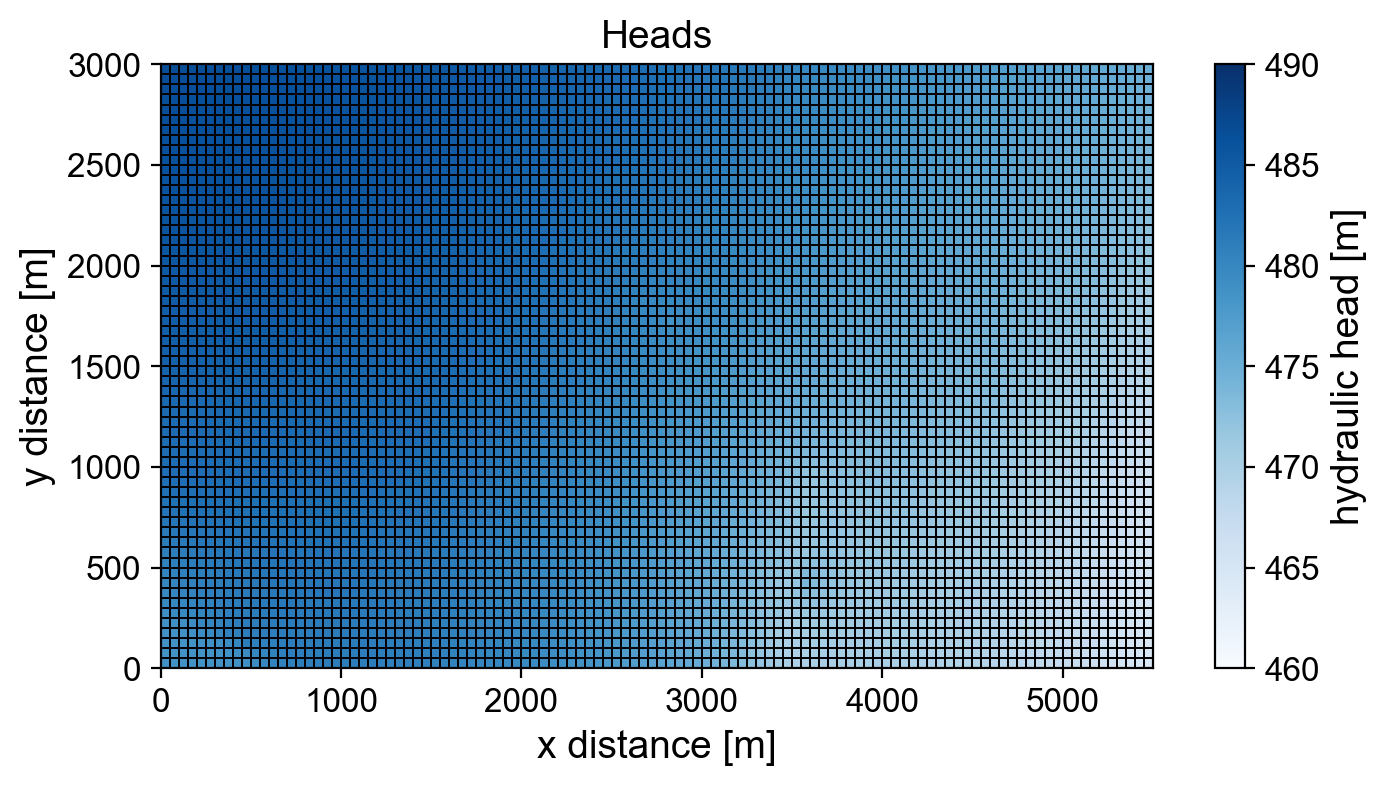

(60, 110)


In [11]:
#import head values from Elliot's model
#note headfile c1 = row, c2 = column, c3 = head values, c4 = layer
head_file = 'C:\\Users\\willg\\OneDrive\\Documents\\2_School\\GraduateSchool\\Fall2021\\!Research\\Geostatistics_paper\\Model_pseudofield_dat.csv' 
head_vals = genfromtxt(head_file, delimiter=',')
#print(head_vals)

#creating the 2d grid of head values
#https://stackoverflow.com/questions/38749140/how-to-make-a-matrix-out-of-existing-xyz-data
x_head = np.unique(head_vals[1:,0]) #rows
# print(x)
y_head = np.unique(head_vals[1:,1]) #cols
# print(y)
X, Y = np.meshgrid(x_head,y_head)

def get_z(mat, x_head, y_head):
    ind = (mat[:,(0,1)] == (x_head,y_head)).all(axis=1)
    row = mat[ind,:]
    return row[0,2]

z = np.array([get_z(head_vals,x_head,y_head) for (x_head,y_head) in zip(np.ravel(X), np.ravel(Y))])

#array of head values
head_values = z.reshape(X.shape)

plot_2d(head_values, 50, 50, 'hydraulic head [m]', 'Heads', 'Blues', [460,490])



#visualize
# plt.contourf(X, Y, head_values, levels = 6, cmap = 'Blues')
# plt.colorbar()
# plt.xlabel('x')
# plt.ylabel('y')
# # plt.gca().invert_xaxis()

#model size and permeability field creation
mod_size = head_values.shape
print(mod_size)

In [12]:
coarse_factor = 2 #or 5
head_values_coarse = coarsen_geomean(head_values, coarse_factor)
mod_size = head_values_coarse.shape
print(mod_size)

(30, 55)


### Define stress periods
Stress period definition: for this model there will be two stress periods. One with no pumping and one with pumping

In [13]:
# perlen (float or array of floats): An array of the stress period lengths.
perlen_mf = [2000, 60000] 
nper = len(perlen_mf)

print(len(perlen_mf))

2


### Define model geometry

In [14]:
# Number of grid cells -- start 2D
nlay = 10
nrow = mod_size[0]
ncol = mod_size[1]


print('Model size: ' + str(nlay) +' layers, ' + str(nrow)+' rows, ' + str(ncol) + ' columns')

z = np.arange(nlay)
y = np.arange(nrow)
x = np.arange(ncol)

Model size: 10 layers, 30 rows, 55 columns


### Heterogeneous Realizations

In [15]:
#Soil properties from randomly sampled points (imagine if this was an actual sample campaign)
#random pseudo sample points
soil_file = 'C:\\Users\\willg\\OneDrive\\Documents\\2_School\\GraduateSchool\\Fall2021\\!Research\\Geostatistics_paper\\random_pts.csv' 
soil_vals = genfromtxt(soil_file, delimiter=',')


x_soil = np.array(soil_vals[1:,0])
y_soil = np.array(soil_vals[1:,1])
z_pseudo = np.array(soil_vals[1:,2])
pos = (z_pseudo, y_soil, x_soil)
#ksat pts
ksat_vals = np.array(soil_vals[1:,5]) #units um/sec
ums_to_mday = (60*60*24)/(10**6)
# print(ums_to_mday)
ksat_mday_vals = np.multiply(ksat_vals, ums_to_mday)
# print(ksat_mday_vals)

#OM
om_vals = np.array(soil_vals[1:,6])
om_vals_frac = np.multiply(om_vals, 1/100)
om_layer = np.full(len(om_vals_frac), 0)
pos_om = (om_layer, y_soil, x_soil)
# print(om_vals_frac)

estimated bin number: 17
maximal bin distance: 40.13199458810112
Exponential(dim=3, var=4.27, len_scale=6.75, nugget=0.215)
estimated bin number: 17
maximal bin distance: 40.13199458810112
Exponential(dim=3, var=0.0181, len_scale=5.81, nugget=0.0548)


C:\Users\willg\anaconda3\envs\GWmodel_v1\lib\site-packages\gstools\covmodel\plot.py:112: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\willg\anaconda3\envs\GWmodel_v1\lib\site-packages\gstools\covmodel\plot.py:112: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


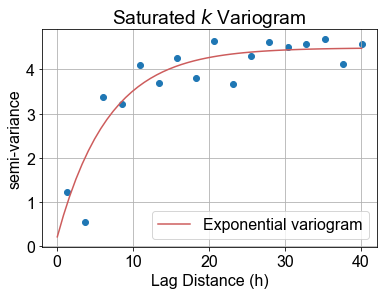

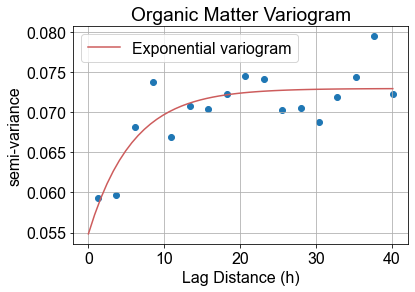

In [16]:
# fig, (ax, ax1) = plt.subplots(2, 1, figsize=(14,8), dpi=300) 
#3D variograms - saturated conduct
bin_center, gamma = gs.vario_estimate(pos, ksat_mday_vals)
print("estimated bin number:", len(bin_center))
print("maximal bin distance:", max(bin_center))

fit_model = gs.Exponential(dim=3)

#note bin center = bns, gamma = variance
fit_model.fit_variogram(bin_center, gamma, nugget=True)
print(fit_model)

ax = fit_model.plot(x_max=max(bin_center), color = 'indianred')
ax.scatter(bin_center, gamma)
ax.set_title('Saturated $k$ Variogram')
ax.set_xlabel('Lag Distance (h)')
ax.set_ylabel('semi-variance')
ax.grid()

#3D variogram Organic Matter Fraction (unused)
bin_center_om, gamma_om = gs.vario_estimate(pos, om_vals_frac)
print("estimated bin number:", len(bin_center_om))
print("maximal bin distance:", max(bin_center_om))

fit_model_om = gs.Exponential(dim=3)

#note bin center = bns, gamma = variance
fit_model_om.fit_variogram(bin_center_om, gamma_om, nugget=True)
print(fit_model_om)

ax1 = fit_model_om.plot(x_max=max(bin_center_om), color = 'indianred')
ax1.scatter(bin_center_om, gamma_om)
ax1.set_title('Organic Matter Variogram')
ax1.set_xlabel('Lag Distance (h)')
ax1.set_ylabel('semi-variance')
ax1.grid()

In [ ]:
#Creating a spatial field based on above variogram... base model -- taking a leap to make it 3D
# field_km2_cond = (cond_srf.structured([z, y, x]))+3
# srf = gs.SRF(fit_model_om)
# srf = (srf.structured([z, x, y]))
# plot_2d(srf[0,:,:], 1, 1, 'values', 'test', 'viridis')

### Conditioning the random field

In [17]:
#krige the model with data points
krige = gs.Krige(fit_model, cond_pos=pos, cond_val=ksat_mday_vals)

In [18]:
cond_srf = gs.CondSRF(krige, seed = 48753)
field_km2_cond = (cond_srf.structured([z, y, x]))+3 #little bit of finegaling to get rid of the negative

geo_mean = np.exp(np.sum(np.log(field_km2_cond))/field_km2_cond.size)

print(geo_mean)

In [19]:
cond_srf1 = gs.CondSRF(krige, seed = 17483)
field_km2_cond1 = (cond_srf1.structured([z, y, x]))+3


In [20]:
cond_srf2 = gs.CondSRF(krige, seed = 4345)
field_km2_cond2 = (cond_srf2.structured([z, y, x]))+3
# field_cond2 = (10**(cond_srf2.structured([x, y, z]) + log_mD))
# field_km2_cond2 = field_cond2*(9.869233E-13/1000)

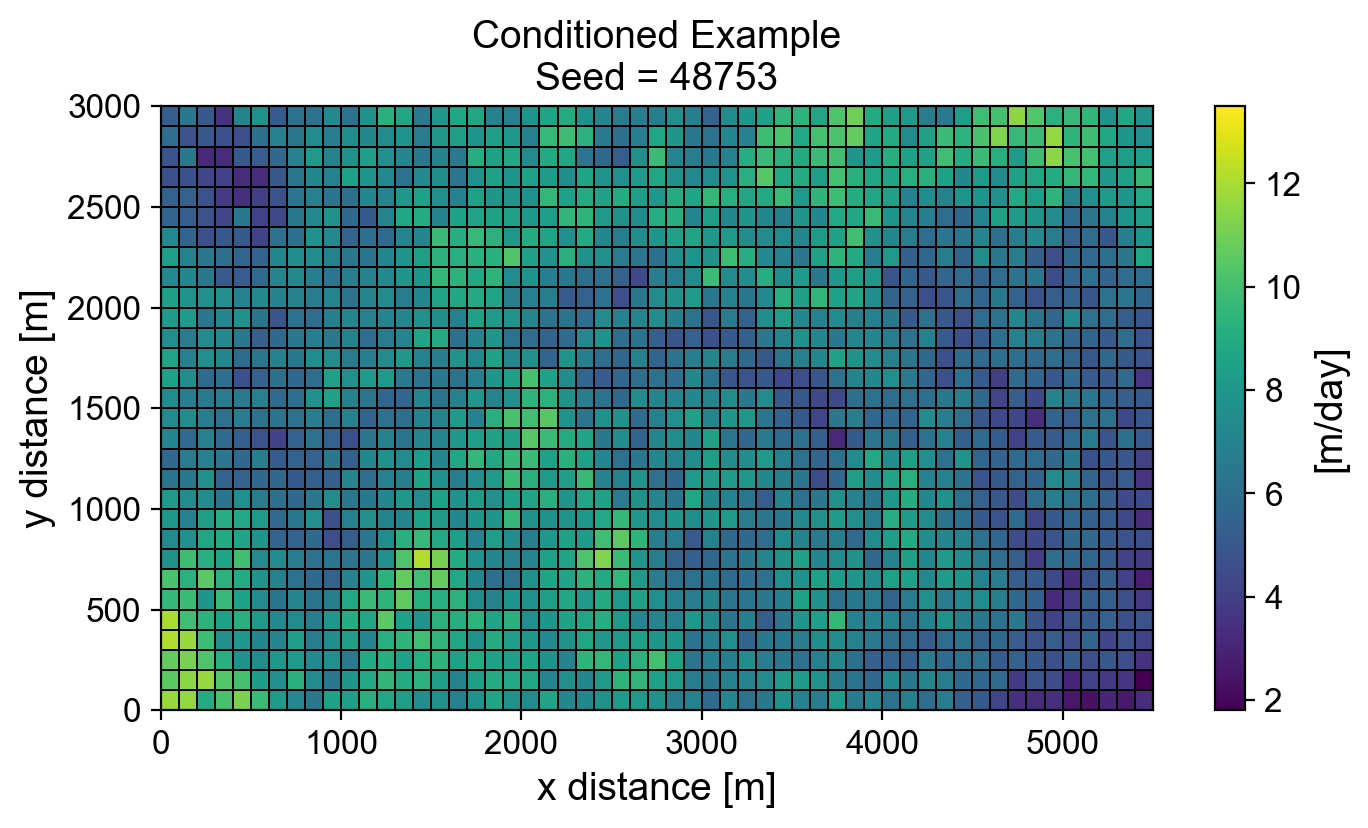

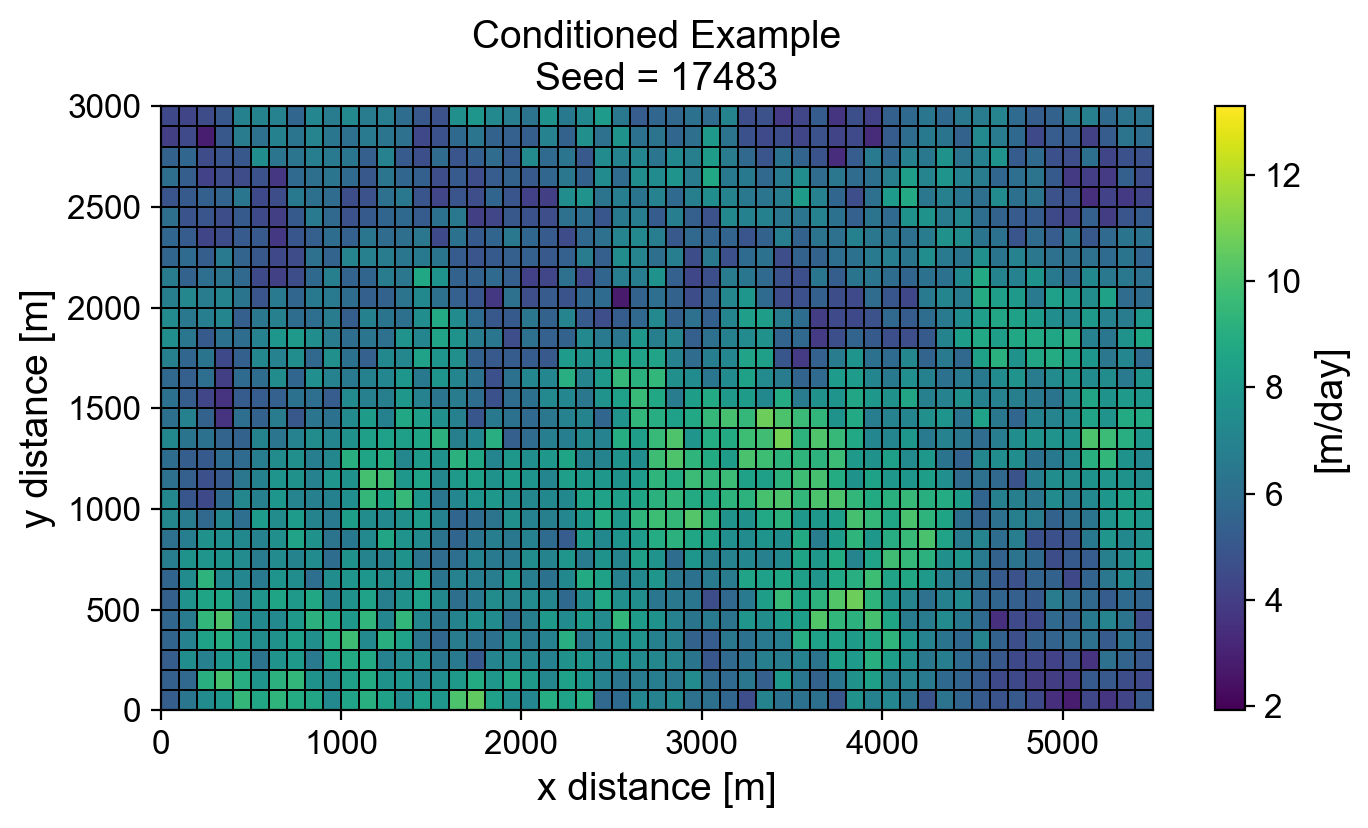

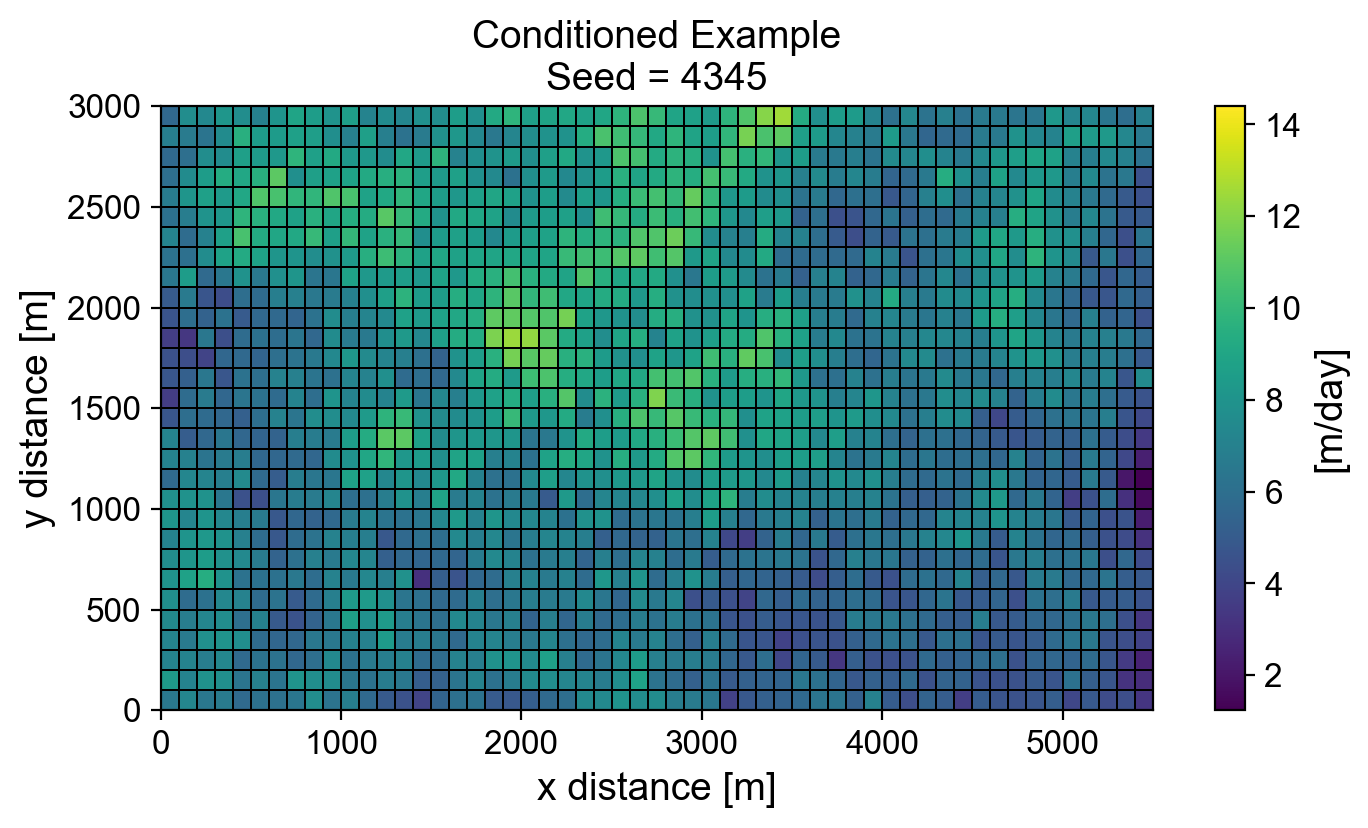

In [21]:
#view along the x-z plane
# fig, (ax, ax1, ax2) = plt.subplots(3, 1, figsize=(14,8), dpi=300) 
layer = 2
plot_2d(field_km2_cond[layer,:,:], 100, 100, '[m/day]','Conditioned Example\nSeed = 48753', 'viridis', [np.min(field_km2_cond), np.max(field_km2_cond)])
# plot_2d(field_km2_cond[:,15,:], 100, 0.5, '[m/day]','Conditioned Example\niteration 1', 'viridis', [np.min(field_km2_cond), np.max(field_km2_cond)])

plot_2d(field_km2_cond1[layer,:,:], 100, 100, '[m/day]','Conditioned Example\nSeed = 17483', 'viridis', [np.min(field_km2_cond1), np.max(field_km2_cond1)])
plot_2d(field_km2_cond2[layer,:,:], 100, 100, '[m/day]','Conditioned Example\nSeed = 4345', 'viridis', [np.min(field_km2_cond2), np.max(field_km2_cond2)])

### Organic carbon content (estimating Kd = Koc*foc)

In [22]:
#averaged foc values for the first 2 layers of the model
foc = np.zeros((nlay, nrow, ncol), dtype=float)
foc[0:1, :, :] = 0.017
print(foc)

[[[0.017 0.017 0.017 ... 0.017 0.017 0.017]
  [0.017 0.017 0.017 ... 0.017 0.017 0.017]
  [0.017 0.017 0.017 ... 0.017 0.017 0.017]
  ...
  [0.017 0.017 0.017 ... 0.017 0.017 0.017]
  [0.017 0.017 0.017 ... 0.017 0.017 0.017]
  [0.017 0.017 0.017 ... 0.017 0.017 0.017]]

 [[0.    0.    0.    ... 0.    0.    0.   ]
  [0.    0.    0.    ... 0.    0.    0.   ]
  [0.    0.    0.    ... 0.    0.    0.   ]
  ...
  [0.    0.    0.    ... 0.    0.    0.   ]
  [0.    0.    0.    ... 0.    0.    0.   ]
  [0.    0.    0.    ... 0.    0.    0.   ]]

 [[0.    0.    0.    ... 0.    0.    0.   ]
  [0.    0.    0.    ... 0.    0.    0.   ]
  [0.    0.    0.    ... 0.    0.    0.   ]
  ...
  [0.    0.    0.    ... 0.    0.    0.   ]
  [0.    0.    0.    ... 0.    0.    0.   ]
  [0.    0.    0.    ... 0.    0.    0.   ]]

 ...

 [[0.    0.    0.    ... 0.    0.    0.   ]
  [0.    0.    0.    ... 0.    0.    0.   ]
  [0.    0.    0.    ... 0.    0.    0.   ]
  ...
  [0.    0.    0.    ... 0.    0.    0. 

### Homogeneous Field

In [23]:
#Homogeneous comparison
homog = np.full((nlay, nrow, ncol), 10) #make this the geometric mean
print(homog.shape)

(10, 30, 55)


### Define flow boundary conditions

In [24]:
# boundary conditions, <0 = specified head, 0 = no flow, >0 variable head
ibound = np.ones((nlay, nrow, ncol), dtype=int)

# # upper = specified head
ibound[:,-1,:] = -1

# # # lower = specified head
ibound[:,0,:] = -1

# # left
ibound[:,:,0] = -1

#right
ibound[:,:,-1] = -1



In [ ]:
print(ibound.shape)
print(ibound[0,:,:].shape)

plot_2d(ibound[1,:,:], 100, 100, 'ibound values', 'Boundary Conditions','magma', [0,1]) #layer one
# plot_2d(ibound[:,1,:], 1, 1, 'ibound values', 'Boundary Conditions','magma') #layer one

### Head conditions

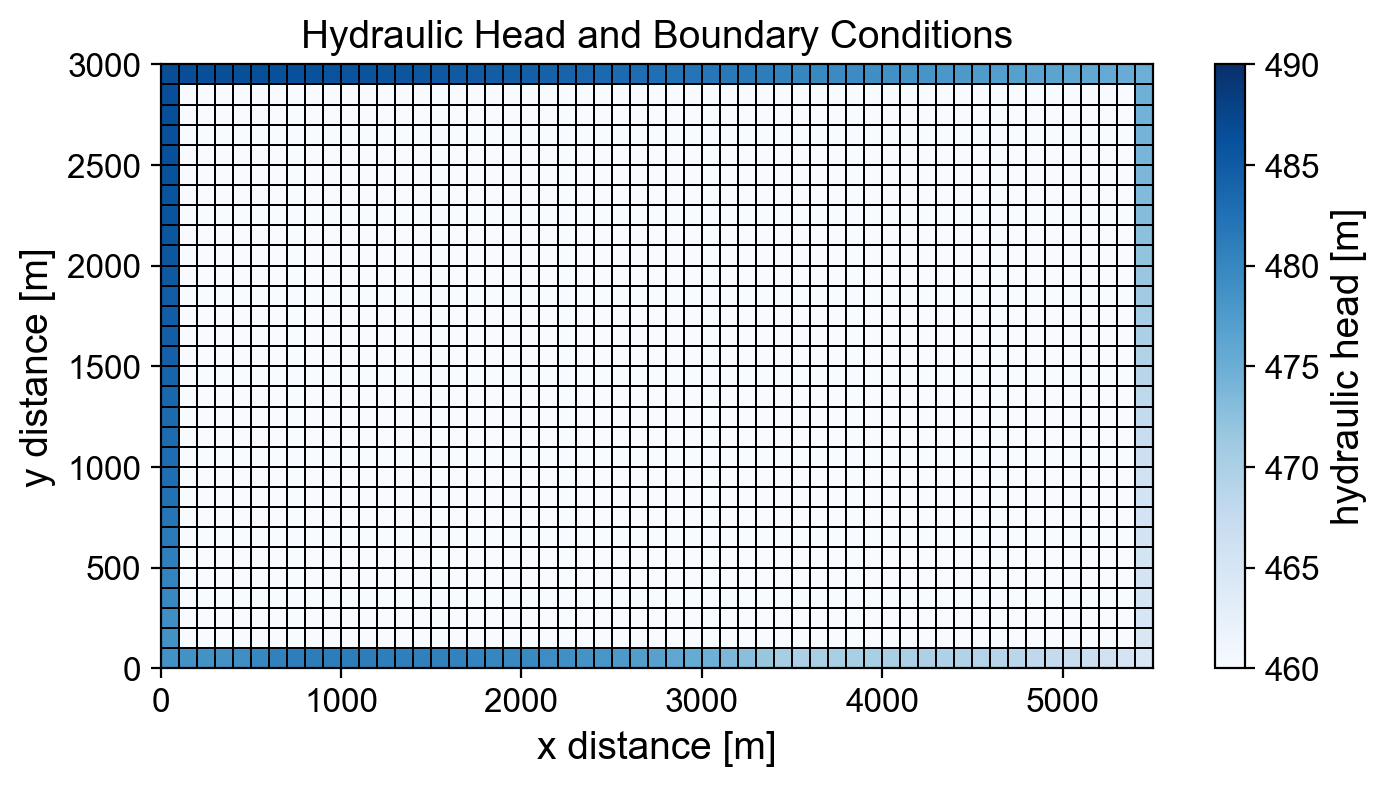

In [25]:
# Now flow initial conditions. All cells where ibound=1 will be solved in the flow model.
# constant head conditions

strt = np.zeros((nlay, nrow, ncol), dtype=float)
strt[:,-1,:] = head_values_coarse[-1,:]
strt[:,0,:] = head_values_coarse[0,:]
strt[:,:,-1] = head_values_coarse[:,-1]
strt[:,:,0] = head_values_coarse[:,0]

plot_2d(strt[0,:,:], 100, 100, 'hydraulic head [m]', 
              'Hydraulic Head and Boundary Conditions', 'Blues', [460, 490])

#=======testing different head conditions===========================================
# x = np.arange(nlay)
# y = np.arange(nrow)
# z = np.arange(ncol)

# model = gs.Gaussian(dim=3, var=0.1, len_scale=20)
# srf = gs.SRF(model)
# strt_test = 10**srf.structured([x, y, z]) #meters?
# plot_2d(strt_test[0,:,:], 1, 1, 'meters', 'Blues')

### Define Flow Wells

In [26]:
# # total flow 
# q = [10, 10, 10] # corresponding to each stress period

# # Stress period well data for MODFLOW. Each well is defined through defintition
# # of layer (int), row (int), column (int), flux (float). The first number corresponds to the stress period
# # Example for 1 stress period: spd_mf = {0:[[0, 0, 1, q],[0, 5, 1, q]]}
# # define well info structure
# well_info = np.zeros((int(nrow), 4), dtype=float) #creates the entire array with the proper size
# # set indices of left face of model
# # well_info[0,:] = 20 
# well_info[:,1] = range(0, nrow)
# # well_info[:,2] = 4
# # set volumetric flow rate
# well_info[:,3] = q[0]
# w = deepcopy(well_info)
# spd_mf={0:w}

# #explicetly defining stress periods for layer (above), row, and col, each with the same q
# well_info[:,3] = q[1]
# # use copy.deepcopy (imported as 'deepcopy') to copy well_info array into dictonary
# # note that if this deepcopy isn't made then when the flow rate it updated
# # in well_info it will update all values copied to dictionary!
# w = deepcopy(well_info)
# # Now insert well information into the MODFLOW stress period data dictionary
# spd_mf.update({1:w})

# well_info[:,3] = q[2]
# # use copy.deepcopy (imported as 'deepcopy') to copy well_info array into dictonary
# # note that if this deepcopy isn't made then when the flow rate it updated
# # in well_info it will update all values copied to dictionary!
# w = deepcopy(well_info)
# # Now insert well information into the MODFLOW stress period data dictionary
# spd_mf.update({2:w})


#Wells 7 and 8 flux m3/day
q0 = 2725.5 + 2180.4
print(q0)
# #may need to be changed depending on the coarsen factor
# welspd_test = {0: [[0, 50, 10, q0]], 1: [[0, 50, 10, q0]], 2: [[0, 10, 50, q0]]}

# welspd_test = {0: [5, 6/coarse_factor, 100/coarse_factor, -q0], 
#                1: [5, 6/coarse_factor, 100/coarse_factor, -q0]}

#lumping wells 7 and 8 together
welspd_test = {0: [9, 34/coarse_factor, 52/coarse_factor, -q0], 
               1: [9, 34/coarse_factor, 52/coarse_factor, -q0]}

obs = [9, 34/coarse_factor, 52/coarse_factor]

4905.9


### Define transport boundary conditions and intitial conditions

In [27]:
# Boundary conditions: if icbund = 0, the cell is an inactive concentration cell; 
# If icbund < 0, the cell is a constant-concentration cell; 
# If icbund > 0, the cell is an active concentration cell where the concentration value will be calculated.
icbund = np.ones((nlay, nrow, ncol), dtype=int)

# Initial conditions: initial concentration zero everywhere
sconc = np.zeros((nlay, nrow, ncol), dtype=float)
# sconc[0, 25, 3] = 1

### Define solute conditions at wells for different stress periods

In [28]:
# Solute transport boundary conditions
# Concentration at well during first stress period
# c = [1, 0, 0] #[1,0,0]

# #MT3D stress period data, note that the indices between 'spd_mt' must exist in 'spd_mf' 
# #This is used as input for the source and sink mixing package
# #Itype is an integer indicating the type of point source, 2=well, 3=drain, -1=constant concentration
# itype = -1
# cwell_info = np.zeros((int(nrow), 5), dtype=float)
# # cwell_info[0,:] = 20
# cwell_info[:,1] = range(0, nrow)
# # cwell_info[:,2] = 4 #range(0, nrow)
# cwell_info[:,3] = c[0]
# # assign itype
# cwell_info[:,4] = itype
# spd_mt = {0:cwell_info}

# # Second stress period        
# cwell_info2 = deepcopy(cwell_info)
# cwell_info2[:,3] = c[1] 
# # Now apply stress period info    
# spd_mt.update({1:cwell_info2})

# # Third stress period        
# cwell_info2 = deepcopy(cwell_info)
# cwell_info2[:,3] = c[2] 
# # Now apply stress period info 
# spd_mt.update({2:cwell_info2})

# print(spd_mt)
c0 = 1
# spd_test = {0: [0, 50, 10, c0, -1], 1: [0, 50, 10, 0.0, -1], 2: [0, 50, 10, 0.0, -1]}

# spd_test = {0: [0, 50/coarse_factor, 6/coarse_factor, c0, -1], 
#             1: [0, 50/coarse_factor, 6/coarse_factor, 0, -1]}

spd_test = {0: [[0, 42/coarse_factor, 10/coarse_factor, c0, -1], 
                [0, 30/coarse_factor, 84/coarse_factor, c0, -1]], 
            1: [[0, 42/coarse_factor, 10/coarse_factor, 0, -1],
                [0, 30/coarse_factor, 84/coarse_factor, 0, -1]]}

In [ ]:
# plt.plot([0, perlen_mf[0]], [q[0], q[0]], color='r', label= 'Flow rate [m/day]')
# plt.plot([perlen_mf[0], perlen_mf[1]], [q[1], q[1]], color='r')
# plt.plot([perlen_mf[1], perlen_mf[2]], [q[2], q[2]], color='r')

# plt.plot([0, perlen_mf[0]], [c[0], c[0]], color='b', label= 'Concentration')
# plt.plot([perlen_mf[0], perlen_mf[1]], [c[1], c[1]], color='b')
# plt.plot([perlen_mf[1], perlen_mf[2]], [c[2], c[2]], color='b')

# plt.plot([perlen_mf[0], perlen_mf[0]], [min(c), max(c)], '--k', label= 'Stress period boundary')
# plt.plot([perlen_mf[1], perlen_mf[1]], [min(c), max(c)], '--k', )
# plt.plot([perlen_mf[2], perlen_mf[2]], [min(c), max(c)], '--k', )

# plt.xlabel('Time [days]')
# plt.ylabel('Concentration / Flow rate')
# plt.legend()

### Run model

In [ ]:
#testing point locations (defined stress periods at locations) - HOMOG
dirname = 'homog_consv'
al = 0.008 # m

#conservative tracer in homogeneous medium

# Call the FloPy model function with this well information - point source input...
mf_hc, mt_hc, conc_hc, cvt_hc, times_hc = model_with_wells(dirname, perlen_mf, al, ibound, strt, icbund, sconc, 
                                       welspd_test, spd_test, nlay, nrow, ncol, homog, foc, 0)

# To understand output size it may be useful to print the shape
print(conc_hc.shape)
grid = mf_h.modelgrid

In [ ]:
dirname = 'homog_rxn'
al = 0.008 # m

#conservative tracer in homogeneous medium

# Call the FloPy model function with this well information - point source input...
mf_h, mt_h, conc_h, cvt_h, times_h = model_with_wells(dirname, perlen_mf, al, ibound, strt, icbund, sconc, 
                                       welspd_test, spd_test, nlay, nrow, ncol, homog, foc, 1)

# To understand output size it may be useful to print the shape
print(conc_h.shape)
grid = mf_h.modelgrid

In [131]:
#HETERO
dirname = 'heterp_norxn_fld0'
al = 0.008 # m

# Call the FloPy model function with this well information - point source input...
mf, mt, conc, cvt, times = model_with_wells(dirname, perlen_mf, al, ibound, strt, icbund, sconc, 
                                       welspd_test, spd_test, nlay, nrow, ncol, field_km2_cond, foc, 0)

# To understand output size it may be useful to print the shape
print(conc.shape)
grid = mf.modelgrid

.\PFAS_test\run02
(32, 10, 30, 55)


In [ ]:
#HETERO
dirname = 'heterp_rxn_fld0'
al = 0.008 # m

# Call the FloPy model function with this well information - point source input...
mf_ht0, mt_ht0, conc_ht0, cvt_ht0, times_ht0 = model_with_wells(dirname, perlen_mf, al, ibound, strt, icbund, sconc, 
                                       welspd_test, spd_test, nlay, nrow, ncol, field_km2_cond, foc, 1)

# To understand output size it may be useful to print the shape
print(conc_ht0.shape)
grid = mf.modelgrid

In [ ]:
#HETERO
dirname = 'heterp_rxn_fld1'
al = 0.008 # m

# Call the FloPy model function with this well information - point source input...
mf_ht1, mt_ht1, conc_ht1, cvt_ht1, times_ht1 = model_with_wells(dirname, perlen_mf, al, ibound, strt, icbund, sconc, 
                                       welspd_test, spd_test, nlay, nrow, ncol, field_km2_cond1, foc, 1)

# To understand output size it may be useful to print the shape
print(conc_ht1.shape)
grid = mf.modelgrid

In [ ]:
#HETERO
dirname = 'heterp_rxn_fld2'
al = 0.008 # m

# Call the FloPy model function with this well information - point source input...
mf_ht2, mt_ht2, conc_ht2, cvt_ht2, times_ht2 = model_with_wells(dirname, perlen_mf, al, ibound, strt, icbund, sconc, 
                                       welspd_test, spd_test, nlay, nrow, ncol, field_km2_cond2, foc, 1)

# To understand output size it may be useful to print the shape
print(conc_ht2.shape)
grid = mf.modelgrid

### Plotting Results 

In [132]:
#better 2d plot
def plot_2d_conc(map_data, dx, dy, colorbar_label, title, cmap, invert):
    # shape information
    r, c = np.shape(map_data)
    # define plot coordinates
    x_coord = np.linspace(0, dx*c, c+1)
    y_coord = np.linspace(0, dy*r, r+1)
    
    X, Y = np.meshgrid(x_coord, y_coord)

    plt.figure(figsize=(8, 4), dpi=200)
    plt.pcolormesh(X, Y, map_data, cmap=cmap, norm=colors.LogNorm(vmin=10**-10, vmax=1), shading = 'auto', edgecolor ='k', linewidth = 0.01)
    plt.gca().set_aspect('auto')  #changed from equal
    # add a colorbar
    cbar = plt.colorbar() 
    # plt.clim(cmin, cmax) 
    # label the colorbar
    cbar.set_label(colorbar_label, fontsize = 14)
    cbar.ax.tick_params(labelsize=12) 
    plt.tick_params(axis='both', which='major', labelsize = 12)
    plt.xlim((0, dx*c)) 
    plt.ylim((0, dy*r)) 
    plt.title(title, fontsize = 14)
    plt.xlabel('x distance [m]', fontsize = 14)
    plt.ylabel('y distance [m]', fontsize = 14)
    if invert == 1:
        plt.gca().invert_yaxis()
    plt.show()

In [ ]:
#Homogeneous results
# early time
layer = 0
# plot_2d(field_km2_cond[layer,:,:], 1, 1, '[m/day]','Conditioned Example\niteration 1', 'viridis')
plot_2d_conc(conc_h[1,layer,:,:]/c0, 100, 100, 'C/C0', 'early conc', 'Reds') #time, layer, row, col
# plot_2d(conc[1,:,6,:]/c0, 1, 1, 'C/C0', 'early conc', 'Reds') #time, layer, row, col

# last time step
plot_2d_conc(conc_h[-1,layer,:,:]/c0, 100, 100, 'C/C0', 'end sim', 'Reds')
# plot_2d(conc[10,:,6,:]/c0, 1, 1, 'C/C0', 'mid conc', 'Reds')

# slice
plot_2d_conc(conc_h[-1,:,15,:]/c0, 1, 1, 'C/C0', 'late conc', 'Reds')

# plot_2d(conc[-1,:,1,:]/c0, 1, 1, 'C/C0', 'late conc', 'Reds')

In [ ]:
# #vector field heads?
# fig = plt.figure(figsize=(12,9))
# ax = fig.add_subplot(1, 1, 1, aspect="equal")
# pmv = flopy.plot.PlotMapView(model=mf, layer=0, ax=ax)
# qm = pmv.plot_ibound()
# lc = pmv.plot_grid()
# qm = pmv.plot_bc("GHB", alpha=0.5)
# cs = pmv.contour_array(head, levels=levels)
# plt.clabel(cs, inline=1, fontsize=10, fmt="%1.1f")
# quiver = pmv.plot_vector(frf, fff)

# # arr = pmv.plot_array(concentration)
# # pmv.plot_vector(qx, qy, -qz, color="white", kstep=3, hstep=3)
# # plt.colorbar(arr, shrink=0.5, ax=ax)
# # ax.set_title("Simulated Concentrations");

# # pmv = flopy.plot.PlotMapView(model=mf, layer=0, ax=ax)
# # qm = pmv.plot_ibound()
# # lc = pmv.plot_grid()
# # qm = pmv.plot_bc("GHB", alpha=0.5)
# # if head.min() != head.max():
# # cs = pmv.contour_array(head, levels=levels)
# # plt.clabel(cs, inline=1, fontsize=10, fmt="%1.1f")
# # quiver = pmv.plot_vector(frf, fff)

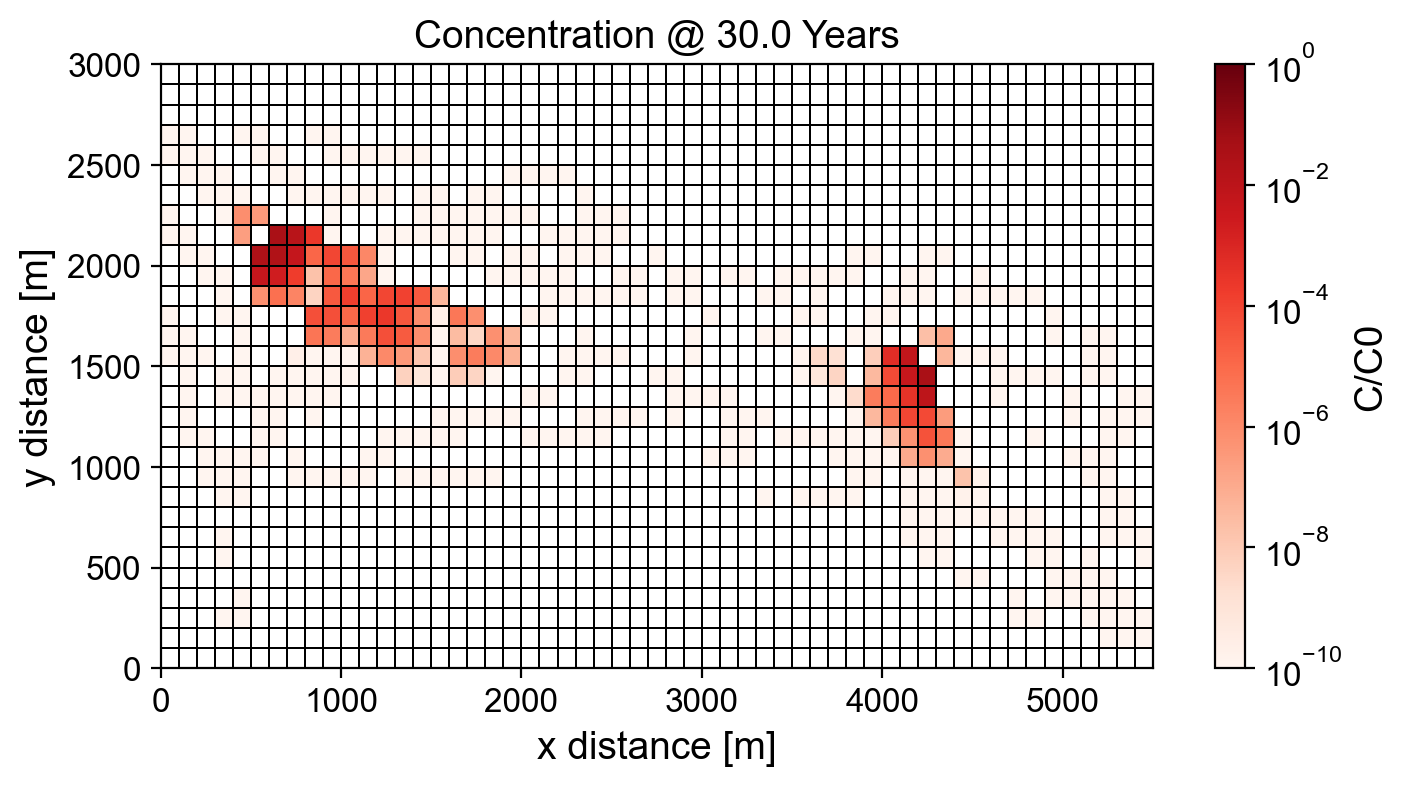

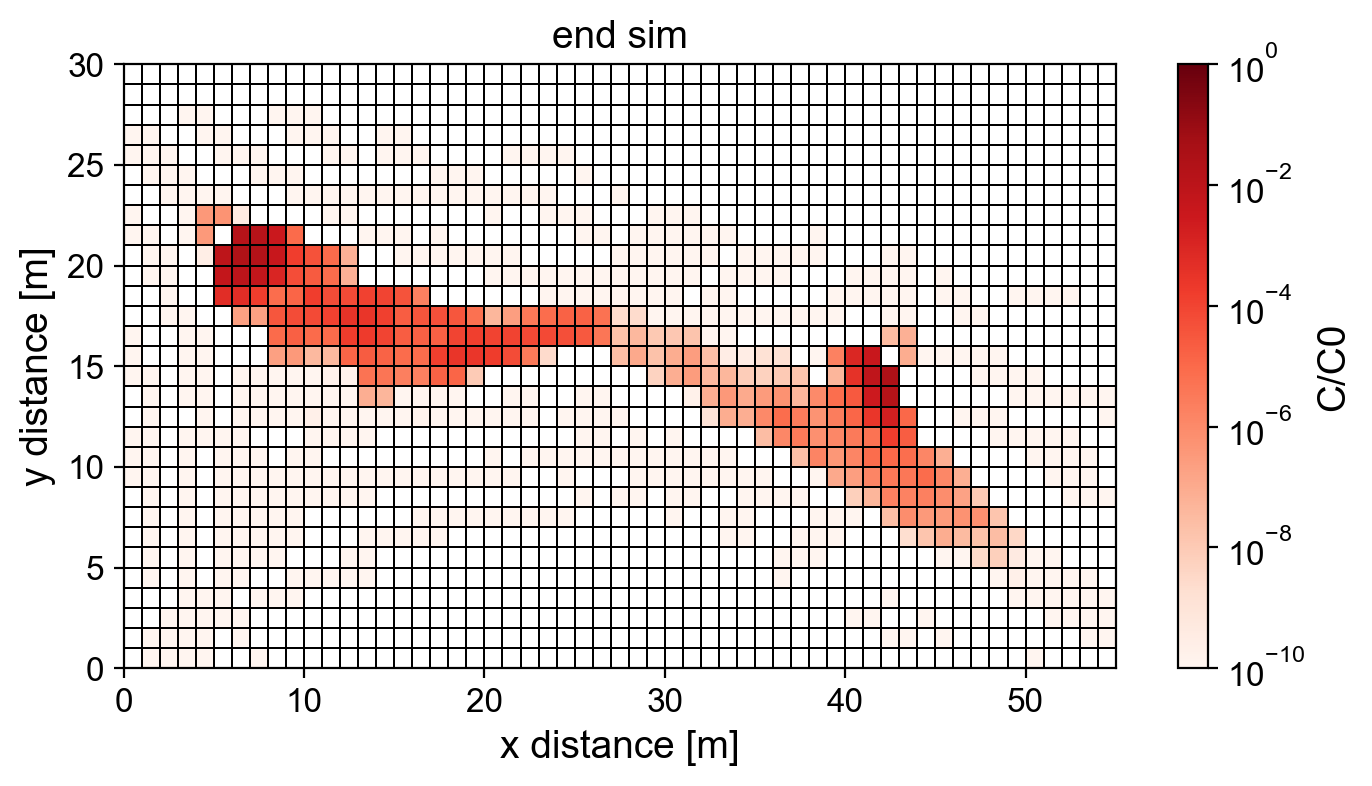

In [133]:
#heterogeneous results
# early time
%matplotlib inline
layer = 0
plot_2d_conc(conc[14,layer,:,:]/c0, 100, 100, 'C/C0', 
             'Concentration @ {} Years'.format(round(times[14]/365, 0)), 'Reds', 0) #time, layer, row, col

# last time step
plot_2d_conc(conc[-1,layer,:,:]/c0, 1, 1, 'C/C0', 'end sim', 'Reds', 0)


# slice
# plot_2d_conc(conc[-1,:,15,:]/c0, 1, 1, 'C/C0', 'late conc', 'Reds', 1)

# plot_2d(conc[-1,:,1,:]/c0, 1, 1, 'C/C0', 'late conc', 'Reds')

C:\Users\willg\anaconda3\envs\GWmodel_v1\lib\site-packages\flopy\modflow\mfdis.py:298: DeprecationWarning: SpatialReference has been deprecated. Use Grid instead.
  warnings.warn(
C:\Users\willg\anaconda3\envs\GWmodel_v1\lib\site-packages\flopy\utils\reference.py:147: DeprecationWarning: SpatialReference has been deprecated and will be removed in version 3.3.5. Use StructuredGrid instead.
  warnings.warn(
C:\Users\willg\anaconda3\envs\GWmodel_v1\lib\site-packages\flopy\utils\reference.py:2074: DeprecationWarning: crs has been deprecated and will be removed in version 3.3.5. Use CRS in shapefile_utils instead.
  warnings.warn(
C:\Users\willg\anaconda3\envs\GWmodel_v1\lib\site-packages\flopy\utils\reference.py:2074: DeprecationWarning: crs has been deprecated and will be removed in version 3.3.5. Use CRS in shapefile_utils instead.
  warnings.warn(


NameError: name 'conc_h' is not defined

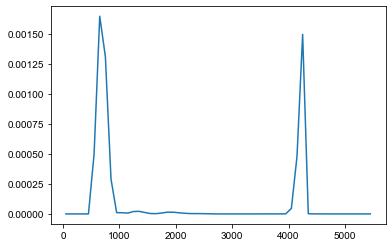

In [134]:
# Extract the model grid cell center location (in selected units, cm in this case)
x = mf.dis.sr.xcenter
# plt.plot(x, np.mean(conc[0, layer, :, :], axis=0), label='ts = 1')
# plt.plot(x, np.mean(conc[50, layer, :, :], axis=0), label='ts = 50')
plt.plot(x, np.mean(conc[-1, layer, :, :], axis=0), label='Mid-time-hetero')
plt.plot(x, np.mean(conc_h[-1, layer, :, :], axis=0), label='Mid-time-homog')
plt.xlabel('X [m]');
# plt.ylim(0,0.4)
plt.legend()
plt.grid()


In [135]:
print(times)

[    0.      840.     1680.     2000.     2520.     3360.     4200.
  5040.     5880.     6720.     7560.     8400.     9240.    10080.
 10920.    11760.    12600.    13440.    14280.    15120.    15960.
 16800.    17640.    18480.    19320.    20160.    21000.    21840.
 22680.    23520.    24360.    24775.941]


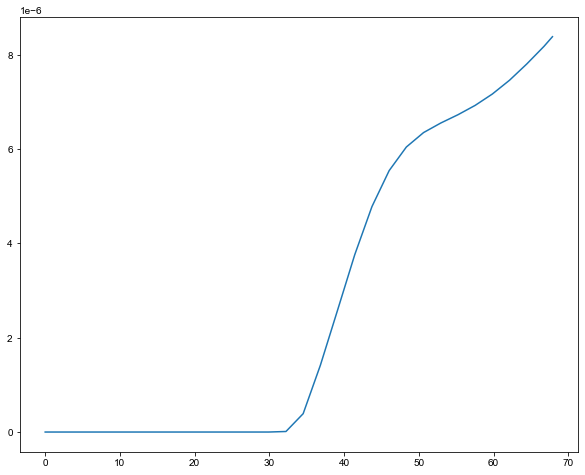

In [138]:
#trying to plot breathru
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(1, 1, 1)

obs_site = [9, 34/coarse_factor, 52/coarse_factor]

C_btc = np.mean([conc[:, 0, 10, 45]], axis=0) #AFFF center
C_btc1 = np.mean([conc[:, 0, 15, 15]], axis=0) #AFFF center

# x = cvt['time']
# y = cvt[obs_site]
# plt.plot(x, y, label="HMOC", marker="d")

# plt.plot(times/365, np.transpose(C_btc))
plt.plot(times/365, np.transpose(C_btc1))

<a list of 2 text.Text objects>

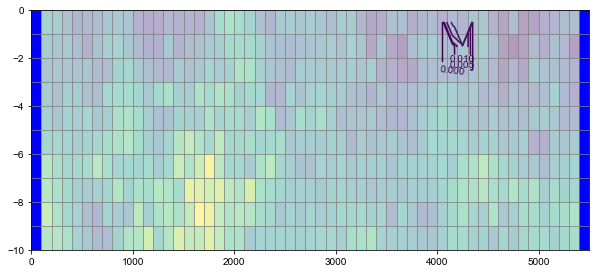

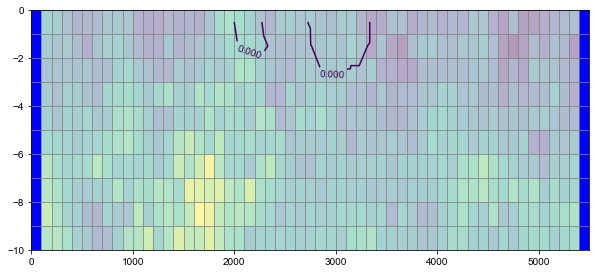

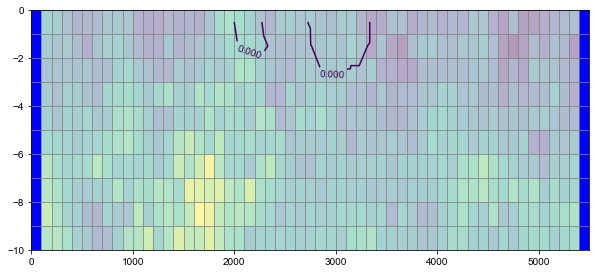

In [105]:
#contour plots, vertical view thru rows
fig = plt.figure(figsize=(10, 15))
hk = mf.lpf.hk.array

lev_test = [0.00001, 0.005, 0.01, 0.025, 0.05, 1]
row_lay = 15

ax = fig.add_subplot(3, 1, 1)
mx = flopy.plot.PlotCrossSection(ax=ax, model=mf, line={"row": row_lay})
mx.plot_array(hk, masked_values=[hk[0, 0, 0]], alpha=0.4)
mx.plot_ibound()
mx.plot_grid(color="0.5", alpha=0.5)
cs = mx.contour_array(
    conc[1], levels=lev_test
)
plt.clabel(cs)

fig = plt.figure(figsize=(10, 15))
hk = mf.lpf.hk.array

ax = fig.add_subplot(3, 1, 1)
mx = flopy.plot.PlotCrossSection(ax=ax, model=mf, line={"row": row_lay})
mx.plot_array(hk, masked_values=[hk[0, 0, 0]], alpha=0.4)
mx.plot_ibound()
mx.plot_grid(color="0.5", alpha=0.5)
cs = mx.contour_array(
    conc[-1], levels=lev_test,
)
plt.clabel(cs)

fig = plt.figure(figsize=(10, 15))
hk = mf.lpf.hk.array

ax = fig.add_subplot(3, 1, 1)
mx = flopy.plot.PlotCrossSection(ax=ax, model=mf, line={"row": row_lay})
mx.plot_array(hk, masked_values=[hk[0, 0, 0]], alpha=0.4)
mx.plot_ibound()
mx.plot_grid(color="0.5", alpha=0.5)
cs = mx.contour_array(
    conc[-1], levels=lev_test
)
plt.clabel(cs)

### 3D plotting

In [ ]:
#https://matplotlib.org/stable/gallery/mplot3d/box3d.html#sphx-glr-gallery-mplot3d-box3d-py
Col, Row, Lay = np.meshgrid(np.arange(ncol), np.arange(nrow), -np.arange(nlay))
fig = plt.figure(figsize=(5, 4))
ax = fig.add_subplot(111, projection='3d')

In [95]:
#slice visualization

# %matplotlib inline
def remove_keymap_conflicts(new_keys_set):
    for prop in plt.rcParams:
        if prop.startswith('keymap.'):
            keys = plt.rcParams[prop]
            remove_list = set(keys) & new_keys_set
            for key in remove_list:
                keys.remove(key)
                
def multi_slice_viewer(volume):
    remove_keymap_conflicts({'j', 'k'})
    fig, ax = plt.subplots()
    ax.volume = volume
    ax.index = volume.shape[0] // 2
    ax.imshow(volume[ax.index], cmap = 'Reds', norm=colors.LogNorm(vmin=10**-10, vmax=1))
    ax.set_title('Concentration Profile')
    fig.canvas.mpl_connect('key_press_event', process_key)

def process_key(event):
    fig = event.canvas.figure
    ax = fig.axes[0]
    if event.key == 'j':
        previous_slice(ax)
    elif event.key == 'k':
        next_slice(ax)
    fig.canvas.draw()

def previous_slice(ax):
    volume = ax.volume
    ax.index = (ax.index - 1) % volume.shape[0]  # wrap around using %
    ax.images[0].set_array(volume[ax.index])

def next_slice(ax):
    volume = ax.volume
    ax.index = (ax.index + 1) % volume.shape[0]
    ax.images[0].set_array(volume[ax.index])

In [96]:
%matplotlib qt
multi_slice_viewer(conc[-1,:,:,:])

In [ ]:
#better 2d plot
def plot_2d_conc(map_data, dx, dy, colorbar_label, title, cmap):
    # shape information
    r, c = np.shape(map_data)
    # define plot coordinates
    x_coord = np.linspace(0, dx*c, c+1)
    y_coord = np.linspace(0, dy*r, r+1)
    
    X, Y = np.meshgrid(x_coord, y_coord)

    plt.figure(figsize=(8, 4), dpi=200)
    plt.pcolormesh(X, Y, map_data, cmap=cmap, shading = 'auto', edgecolor ='k', linewidth = 0.05)
    plt.gca().set_aspect('auto')  #changed from equal
    # add a colorbar
    cbar = plt.colorbar() 
    # plt.clim(cmin, cmax) 
    # label the colorbar
    cbar.set_label(colorbar_label, fontsize = 14)
    cbar.ax.tick_params(labelsize=12) 
    plt.tick_params(axis='both', which='major', labelsize = 12)
    plt.xlim((0, dx*c)) 
    plt.ylim((0, dy*r)) 
    plt.title(title, fontsize = 14)
    plt.xlabel('x distance [m]', fontsize = 14)
    plt.ylabel('y distance [m]', fontsize = 14)
    plt.show()